In [1]:
## basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

## statistics
from scipy.stats import zscore
from scipy.stats import ttest_rel ## paired t-test
from scipy.stats import ttest_ind ## two-sample t-test


## system
import os
import pickle
import warnings
warnings.filterwarnings("ignore")

##
import PyComplexHeatmap as pyc
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

## Define Helper Functions

In [2]:
def scale(df,
          method="standard"):
    
    if method == "standard":
        scaler = StandardScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(df),
                                 index = df.index,
                                 columns = df.columns)
        return df_scaled

    if method == "double_z":
        df_scaled = df.apply(zscore,axis=1).\
            apply(zscore, axis=0)

    else:
        df_scaled = df

    return df_scaled

def umap_wrapper(df,
                 df_meta,
                 n_pca=10,
                 remove_PC1=True,
                 n_neighbors=15,
                 n_umap=3,
                 learning_rate=1,
                 min_dist=0.1,
                 spread = 1,
                 metric="euclidean",
                 random_state=42):

    assert min_dist <= spread

    print(f"Input data dimension: {df.shape}")
    print(f"Input meta-data dimension: {df_meta.shape}")
    
    ## perform linear PCA
    pca = PCA(n_components=n_pca)
    df_pca = pd.DataFrame(pca.fit_transform(df),
                          columns = ["PC" + str(i) for i in range(1, n_pca+1)],
                          index = df.index)

    ## remove "PC1"
    if remove_PC1:
        df_pca = df_pca.drop("PC1",axis=1)
    
    print(f"Dimension after PCA: {df_pca.shape}")

    ## UMAP
    umap_embedding = umap.UMAP(n_neighbors=n_neighbors,
                               n_components=n_umap, 
                               learning_rate=learning_rate,
                               min_dist=min_dist,
                               spread = spread,
                               metric=metric,
                               random_state=random_state)
    
    df_umap = pd.DataFrame(umap_embedding.fit_transform(df_pca),
                       columns = ["UMAP" + str(i) for i in range(1, n_umap+1)],
                       index = df_pca.index)

    print(f"Dimension after UMAP: {df_umap.shape}")
    
    ## merge meta-data
    df_umap = pd.merge(df_meta, df_umap, left_index=True, right_index=True)
    df_pca = pd.merge(df_meta, df_pca, left_index=True, right_index=True)

    print(f"Dimension after merging: {df_umap.shape}")

    return df_umap, df_pca

def age_binned(age):
    
    if age <= 45:
        return "age < 45"
    if 45 < age <= 55:
        return " 45 < age <= 55"
    if 55 < age <= 65:
         return " 55 < age <= 65"
    if 65 < age <= 75:
         return " 65 < age <= 75"
    
    if 75 < age <= 85:
         return " 75 < age <= 85"

    return "> 85"

## Load Data

In [3]:
with open('/screening/notebooks/zhuang/summer_2024/data/region_ids.pkl', 'rb') as f:
        region_ids = pickle.load(f)

with open('/screening/notebooks/zhuang/summer_2024/data/df_ldt.pkl', 'rb') as f:
        df_ldt = pickle.load(f)

## Query region meta-data to obtain "positive_control" regions
v6_region = "/screening/data/methylation/sandbox_pipeline/assets/mafband_v2023_12_23/msre_regions.tsv"
pos_control = pd.read_csv(v6_region, sep="\t").\
    query('merged_region_type == "HYPER_CONTROL"').\
    loc[:,"region_id"].\
    reset_index(drop=True)
pos_control_in_s3 = [i for i in pos_control if i in region_ids]

print(f"There are {len(pos_control_in_s3)} positive control regions in S3")

## Prediction from Lung Model: MB_S3_V4
called_samples = pd.read_csv("../data/called_discovery_lung_samples.tsv",sep="\t").\
    assign(called = lambda df: np.where(df['sample_group'] == "cancer_free", "FP", "TP"))

not_called_samples = pd.read_csv("../data/not_called_discovery_lung_samples.tsv", sep="\t").\
    assign(called = lambda df: np.where(df['sample_group'] == "cancer_free", "TN", "FN"))

lung_MB_S3_V4 =  pd.concat([called_samples, not_called_samples],axis=0).\
    loc[:,["unique_sample_id","called"]].\
    set_index("unique_sample_id")

## subset data
df_cf = df_ldt.loc[:,["unique_sample_id","sample_group","age","sex", "histological_subtype", 'g360_max_maf_pct', 'tvf_max_maf_pct']+region_ids].\
    query('sample_group == "cancer_free"').\
    set_index("unique_sample_id").\
    drop(pos_control_in_s3,axis=1)

#df_cf = pd.merge(df_cf, lung_MB_S3_V4, left_index = True, right_index = True, how = "left")

print(f"Cancer_free data dimension: {df_cf.shape}")

df_lung = df_ldt.loc[:,["unique_sample_id","sample_group","age","sex","histological_subtype", 'g360_max_maf_pct', 'tvf_max_maf_pct']+region_ids].\
    query('sample_group == "lung"').\
    set_index("unique_sample_id").\
    drop(pos_control_in_s3,axis=1).\
    assign(histological_subtype = lambda df: np.where(df['histological_subtype'].isin(['adenocarcinoma', 'squamous_cell_carcinoma']), df['histological_subtype'], "unknown"),
          log_g360_maf = lambda df: np.log(df['g360_max_maf_pct']),
          log_tvf_maf =  lambda df: np.log(df['tvf_max_maf_pct']))

df_lung = pd.merge(df_lung, lung_MB_S3_V4, left_index = True, right_index = True, how = "left")

print(f"Lung data dimension: {df_lung.shape}")

There are 41 positive control regions in S3
Cancer_free data dimension: (995, 27307)
Lung data dimension: (996, 27310)


## Load Region Data

In [4]:
## p80-p100
## drop NaN
## inf = high ~ 10
## sens_threshold = 50
## lod = -1 = bad

#top = 5000
snr = pd.read_csv(os.getcwd()+"/../data/snrs.tsv",sep="\t").\
    query('sample_group == "lung"').\
    replace(np.inf, 40).\
    sort_values("snr_p100",ascending=False).\
    set_index("region_id")
    

LoD = pd.read_csv(os.getcwd()+"/../data/tvf_max_maf_pct_90_lods.tsv",sep="\t").\
    query('sample_group_cancer == "lung" and lod != -1 and sens_threshold==50 and lod <= 1').\
    set_index("region_id").\
    assign(log_lod = lambda df: np.log(df['lod']))

region_anno = pd.merge(LoD, snr, left_index=True, right_index=True, how="left")

## V6
v6_regions = pd.read_csv(v6_region, sep="\t").\
    query('merged_region_type != "HYPER_CONTROL"').\
    assign(panel = "V6").\
    loc[:,["region_id","panel"]].\
    set_index("region_id")

## region annotation
region_anno["in_v6"] = ["yes" if i in v6_regions.index else "no" for i in region_anno.index]

## regions of interest
regions_of_interest = list(region_anno.index)

print(f"There are {len(regions_of_interest)} regions of interest")

There are 1028 regions of interest


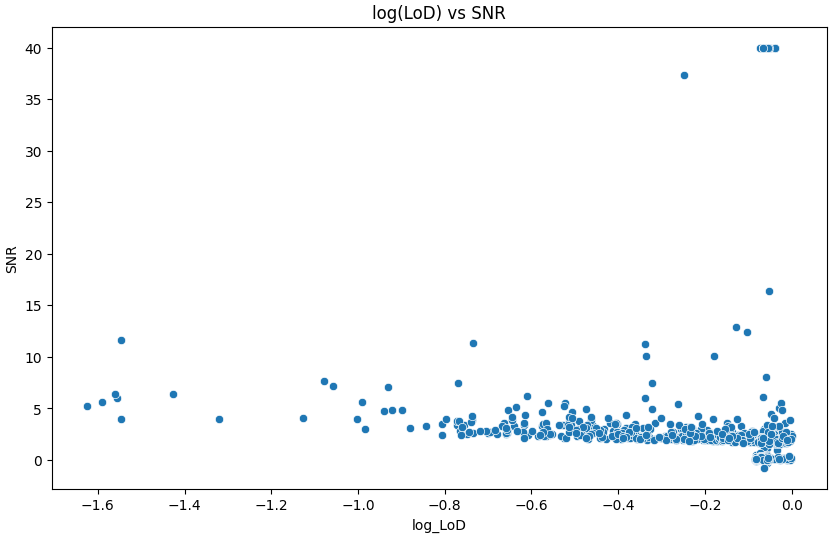

In [5]:
fig, axes = plt.subplots(figsize=(10,6))
        
with plt.style.context('_classic_test_patch'):
        
    sns.scatterplot(x="log_lod",
                    y="snr_p100",
                    data=region_anno)
    axes.set_xlabel("log_LoD")
    axes.set_ylabel("SNR")
    axes.set_title("log(LoD) vs SNR")

## More information

In [6]:
tvf2 = pd.read_csv("../data/tfv2gamma.tsv",sep="\t").\
    rename(columns={"value":"tumor_fraction"})

## for Cancer-free vs. CRC
mb = pd.read_csv("../data/merged.msre_mr_call.hdr.tsv",sep="\t")

tvf2_mb = pd.merge(tvf2, mb, on = ["runid","run_sample_id"], how="inner").\
    set_index("unique_sample_id").\
    drop(["runid", "run_sample_id", "norm_flavor", "metric", "hyper_residual_count_pos_ctrl", "model_name"], axis=1)


## merge to cancer-free and lung samples
df_cf = pd.merge(df_cf, tvf2_mb, how="left", left_index=True, right_index=True)

df_lung = pd.merge(df_lung, tvf2_mb, how="left", left_index=True, right_index=True)

## Pair-wise correlation (w/o filtering pos-control regions)

### Sample-level & region level

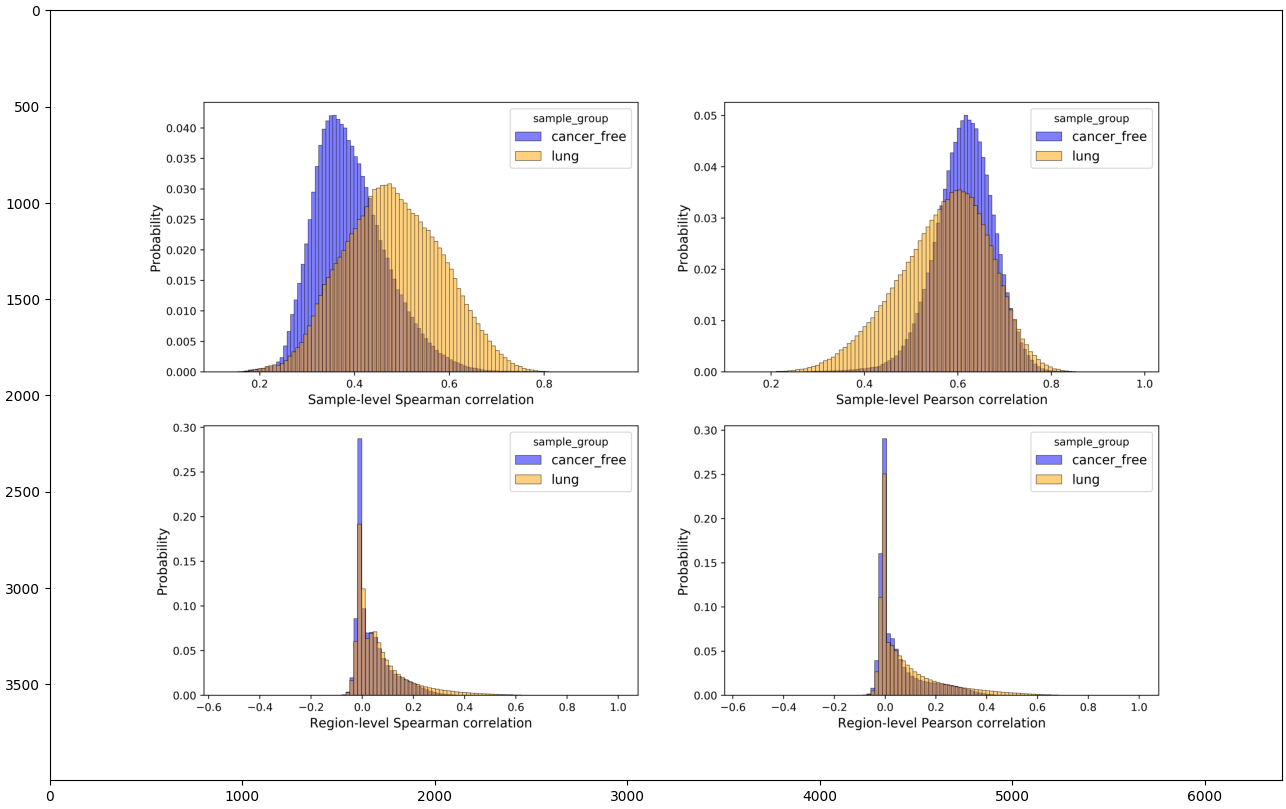

In [7]:
run = False

if run:
    
    ## Spearman (sample)
    with open('/screening/notebooks/zhuang/summer_2024/data/sample_cancer_free_corr_sp.pkl', 'rb') as f:
        sample_cancer_free_corr_sp = pickle.load(f)
    
    with open('/screening/notebooks/zhuang/summer_2024/data/sample_lung_corr_sp.pkl', 'rb') as f:
        sample_lung_corr_sp = pickle.load(f)

    ## Spearman (region)
    with open('/screening/notebooks/zhuang/summer_2024/data/region_cancer_free_corr_sp.pkl', 'rb') as f:
        region_cancer_free_corr_sp = pickle.load(f)
    
    with open('/screening/notebooks/zhuang/summer_2024/data/region_lung_corr_sp.pkl', 'rb') as f:
        region_lung_corr_sp = pickle.load(f)


   ## Pearson (sample)
    with open('/screening/notebooks/zhuang/summer_2024/data/sample_cancer_free_corr_pe.pkl', 'rb') as f:
        sample_cancer_free_corr_pr = pickle.load(f)
    
    with open('/screening/notebooks/zhuang/summer_2024/data/sample_lung_corr_pe.pkl', 'rb') as f:
        sample_lung_corr_pr = pickle.load(f)

    ## Pearson
    with open('/screening/notebooks/zhuang/summer_2024/data/region_cancer_free_corr_pe.pkl', 'rb') as f:
        region_cancer_free_corr_pr = pickle.load(f)
    
    with open('/screening/notebooks/zhuang/summer_2024/data/region_lung_corr_pe.pkl', 'rb') as f:
        region_lung_corr_pr = pickle.load(f)

    
    fig, axes = plt.subplots(2,2,figsize=(16,10))
        
    with plt.style.context('_classic_test_patch'):
        
        ## cancer_free vs. lung (sample)
        sns.histplot(sample_cancer_free_corr_sp,
                     bins = 100,
                     label = "cancer_free",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "blue",
                     ax = axes[0,0])
    
        sns.histplot(sample_lung_corr_sp,
                     bins = 100,
                     label = "lung",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "orange",
                     ax = axes[0,0])
        
        axes[0,0].legend(title = 'sample_group', fontsize=12)
        axes[0,0].set_xlabel('Sample-level Spearman correlation', fontsize=12)
        axes[0,0].set_ylabel('Probability', fontsize=12)
    
        sns.histplot(sample_cancer_free_corr_pr,
                     bins = 100,
                     label = "cancer_free",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "blue",
                     ax = axes[0,1])
    
        sns.histplot(sample_lung_corr_pr,
                     bins = 100,
                     label = "lung",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "orange",
                     ax = axes[0,1])
        
        axes[0,1].legend(title = 'sample_group', fontsize=12)
        axes[0,1].set_xlabel('Sample-level Pearson correlation', fontsize=12)
        axes[0,1].set_ylabel('Probability', fontsize=12)

        ## cancer_free vs. lung (region)
        sns.histplot(region_cancer_free_corr_sp,
                     bins = 100,
                     label = "cancer_free",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "blue",
                     ax = axes[1,0])
    
        sns.histplot(region_lung_corr_sp,
                     bins = 100,
                     label = "lung",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "orange",
                     ax = axes[1,0])
        
        axes[1,0].legend(title = 'sample_group', fontsize=12)
        axes[1,0].set_xlabel('Region-level Spearman correlation', fontsize=12)
        axes[1,0].set_ylabel('Probability', fontsize=12)
    
        sns.histplot(region_cancer_free_corr_pr,
                     bins = 100,
                     label = "cancer_free",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "blue",
                     ax = axes[1,1])
    
        sns.histplot(region_lung_corr_pr,
                     bins = 100,
                     label = "lung",
                     kde = False,
                     alpha = 0.5,
                     stat = 'probability',
                     color = "orange",
                     ax = axes[1,1])
        
        axes[1,1].legend(title = 'sample_group', fontsize=12)
        axes[1,1].set_xlabel('Region-level Pearson correlation', fontsize=12)
        axes[1,1].set_ylabel('Probability', fontsize=12)

  # Save the figure
        fig.savefig(os.getcwd() + "/../results/cf_lung_corr.png", dpi=400)

else:
    fig, ax = plt.subplots(figsize=(16,10))
    img = Image.open(os.getcwd() + "/../results/cf_lung_corr.png")
    ax.imshow(img)

## Preprocess Data

In [ ]:
pdata_cf = ["sample_group", "age" ,"sex", "histological_subtype", "g360_max_maf_pct", "tvf_max_maf_pct", "tumor_fraction", "methyl_score", "threshold", "methyl_call"]

pdata_lung = ["sample_group","age","sex", "histological_subtype", "g360_max_maf_pct", "tvf_max_maf_pct", "log_g360_maf", "log_tvf_maf", "called","tumor_fraction", "methyl_score", "threshold", "methyl_call"]

## meta-data
df_cf_meta = df_cf.loc[:,pdata_cf]

df_lung_meta = df_lung.loc[:,pdata_lung]


## region score and scaling
df_cf_region = df_cf.drop(pdata_cf,axis=1)

df_cf_standard = scale(df_cf_region,
                       method = "standard")

df_cf_double_z = scale(df_cf_region,
                        method = "double_z")

df_lung_region = df_lung.drop(pdata_lung,axis=1)

df_lung_standard = scale(df_lung_region,
                         method = "standard")

df_lung_double_z = scale(df_lung_region,
                    method = "double_z")

## subset regions to regions_of_interest
cols = [col for col in df_cf_standard.columns if col in regions_of_interest]
print(f"There are {len(cols)} regions of interest")

df_cf_standard_roi = df_cf_standard[cols]
df_cf_double_z_roi = df_cf_double_z[cols]

df_lung_standard_roi = df_lung_standard[cols]
df_lung_double_z_roi = df_lung_double_z[cols]

## Linear PCA Explained Variance Ratio and Correlation with MAF

In [ ]:
def pca_wrapper(df,
                maf=None,
                n=10):
    pca = PCA(n_components=n)
    
    df_pca = pd.DataFrame(pca.fit_transform(df),
                      index = df.index)    

    if maf:
        df_pca['maf'] = maf
    
        print(df_pca.columns[-1])
    
        maf_corr = df_pca.dropna().\
        iloc[:,:-1].\
        apply(lambda x: x.corr(df.iloc[:,-1]))
    
        var_ratio = pca.explained_variance_ratio_


        return var_ratio, maf_corr
    else:
        return pca.explained_variance_ratio_

### Cancer_free

In [ ]:
n = 10

var_ratio_cf_standard = pca_wrapper(df_cf_standard,
                                    n = n)

var_ratio_cf_z = pca_wrapper(df_cf_double_z,
                             n = n)

fig, axes = plt.subplots(1,2,figsize=(10,4))

with plt.style.context('_classic_test_patch'):

        ## cancer_free+standard
        sns.barplot(x = list(range(1, n+1)),
                    y = var_ratio_cf_standard,
                    width = 0.25,
                    alpha = 0.5,
                    align = "center",
                    ax = axes[0])
    
        axes[0].set_title("Cancer_free+Standard", fontsize=12)
        axes[0].set_xlabel("PCs", fontsize=10)
        axes[0].set_ylabel("Explained Variance Ratio", fontsize=10)

    
        sns.barplot(x = list(range(1, n+1)),
                    y = var_ratio_cf_z,
                    width = 0.25,
                    alpha = 0.5,
                    align = "center",
                    ax = axes[1])
    
        axes[1].set_title("Cancer_free+Double_z", fontsize=12)
        axes[1].set_xlabel("PCs", fontsize=10)
        axes[1].set_ylabel("Explained Variance Ratio", fontsize=10)


### Lung

In [ ]:
n = 10

var_ratio_lung_standard, g360_maf_corr_lung_standard = pca_wrapper(df_lung_standard,
                                                                    maf = list(df_lung_meta['g360_max_maf_pct']),
                                                                      n = n)

var_ratio_lung_z, g360_maf_corr_lung_z = pca_wrapper(df_lung_double_z,
                                                     maf = list(df_lung_meta['g360_max_maf_pct']),
                                                     n = n)

_, tvf_maf_corr_lung_standard = pca_wrapper(df_lung_standard,
                                            maf = list(df_lung_meta['tvf_max_maf_pct']),
                                            n = n)

_, tvf_maf_corr_lung_z = pca_wrapper(df_lung_double_z,
                                     maf = list(df_lung_meta['tvf_max_maf_pct']),
                                     n = n)

fig, axes = plt.subplots(2,3,figsize=(20,14))

with plt.style.context('_classic_test_patch'):

        ## lung+standard
        sns.barplot(x = list(range(1, n+1)),
                    y = var_ratio_lung_standard,
                    width = 0.25,
                    alpha = 0.5,
                    align = "center",
                    ax = axes[0,0])
    
        axes[0,0].set_title("Explained Variance Ratio(lung+standard)", fontsize=12)
        axes[0,0].set_xlabel("PCs", fontsize=10)
        axes[0,0].set_ylabel("Ratio", fontsize=10)

    
        sns.barplot(x = list(range(1, n+1)),
                    y = g360_maf_corr_lung_standard,
                    width = 0.25,
                    alpha = 0.5,
                    align = "center",
                    ax = axes[0,1])
    
        axes[0,1].set_title("Correlation with g360_MAF(lung+standard)", fontsize=12)
        axes[0,1].set_xlabel("PCs", fontsize=10)
        axes[0,1].set_ylabel("Correlation", fontsize=10)

        sns.barplot(x = list(range(1, n+1)),
                    y = tvf_maf_corr_lung_standard,
                    width = 0.25,
                    alpha = 0.5,
                    align = "center",
                    ax = axes[0,2])
    
        axes[0,2].set_title("Correlation with tvf_MAF(lung+standard)", fontsize=12)
        axes[0,2].set_xlabel("PCs", fontsize=10)
        axes[0,2].set_ylabel("Correlation", fontsize=10)

        
    
        ## lung + double_z
        sns.barplot(x = list(range(1, n+1)),
                    y = var_ratio_lung_z,
                    width = 0.25,
                    alpha = 0.5,
                    align = "center",
                    ax = axes[1,0])
    
        axes[1,0].set_title("Explained Variance Ratio(lung+double_z)", fontsize=12)
        axes[1,0].set_xlabel("PCs", fontsize=10)
        axes[1,0].set_ylabel("Ratio", fontsize=10)

    
        sns.barplot(x = list(range(1, n+1)),
                    width = 0.25,
                    y = g360_maf_corr_lung_z,
                    alpha = 0.5,
                    align = "center",
                    ax = axes[1,1])
    
        axes[1,1].set_title("Correlation with g360_MAF(lung+double_z)", fontsize=12)
        axes[1,1].set_xlabel("PCs", fontsize=10)
        axes[1,1].set_ylabel("Correlation", fontsize=10)

        sns.barplot(x = list(range(1, n+1)),
                    width = 0.25,
                    y = tvf_maf_corr_lung_z,
                    alpha = 0.5,
                    align = "center",
                    ax = axes[1,2])

        axes[1,2].set_title("Correlation with tvf_MAF(lung+double_z)", fontsize=12)
        axes[1,2].set_xlabel("PCs", fontsize=10)
        axes[1,2].set_ylabel("Correlation", fontsize=10)

## Cancer_free

### Linear PCA + UMAP

- Use standard scaling or double-z scores
- Perform linear PCA and use the top 10-20 PCs
- Perform UMAP in the PC-space

In [ ]:
umap_cf_standard, pca_cf_standard = umap_wrapper(df_cf_standard,
                                                 df_cf_meta,
                                                 n_pca=10,
                                                 remove_PC1=False,
                                                 n_neighbors=15,
                                                 n_umap=3,
                                                 learning_rate=0.1,
                                                 min_dist=0.1,
                                                 spread=1,
                                                 metric="euclidean",
                                                 random_state=42)

umap_cf_z, pca_cf_z = umap_wrapper(df_cf_double_z,
                                   df_cf_meta,
                                   n_pca=15,
                                   remove_PC1=False,
                                   n_neighbors=10,
                                   n_umap=3,
                                   learning_rate=0.1,
                                   min_dist=0.1,
                                   spread=1,
                                   metric="euclidean",
                                   random_state=42)

In [ ]:
hue = "tumor_fraction"

fig, axes = plt.subplots(2,3, figsize=(24,16))
with plt.style.context('_classic_test_patch'):

    ## UMAP 1 vs. UMAP 2
    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = hue,
                    data = umap_cf_standard,
                    ax = axes[0,0])
        
    axes[0,0].set_title("UMAP1 vs UMAP2 (standard)", fontsize=12)
    axes[0,0].set_xlabel("UMAP 1", fontsize=10)
    axes[0,0].set_ylabel("UMAP 2", fontsize=10)

    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = hue,
                    data = umap_cf_z,
                    ax = axes[1,0])
        
    axes[1,0].set_title("UMAP1 vs UMAP2 (double_z)", fontsize=12)
    axes[1,0].set_xlabel("UMAP 1", fontsize=10)
    axes[1,0].set_ylabel("UMAP 2", fontsize=10)

    ## PC 1 vs. PC 2
    sns.scatterplot(x = "PC1",
                    y = "PC2",
                    hue = hue,
                    data = pca_cf_standard,
                    ax = axes[0,1])
        
    axes[0,1].set_title("PC1 vs. PC2 (standard)", fontsize=12)
    axes[0,1].set_xlabel("PC1 1", fontsize=10)
    axes[0,1].set_ylabel("PC 2", fontsize=10)

    sns.scatterplot(x = "PC1",
                    y = "PC2",
                    hue = hue,
                    data = pca_cf_z,
                    ax = axes[1,1])
        
    axes[1,1].set_title("PC1 vs. PC2 (double_z)", fontsize=12)
    axes[1,1].set_xlabel("PC1 1", fontsize=10)
    axes[1,1].set_ylabel("PC 2", fontsize=10)

    ## PC 2 vs. PC 3
    sns.scatterplot(x = "PC2",
                    y = "PC3",
                    hue = hue,
                    data = pca_cf_standard,
                    ax = axes[0,2])
        
    axes[0,2].set_title("PC2 vs. PC3 (standard)", fontsize=12)
    axes[0,2].set_xlabel("PC1 2", fontsize=10)
    axes[0,2].set_ylabel("PC 3", fontsize=10)

    sns.scatterplot(x = "PC2",
                    y = "PC3",
                    hue = hue,
                    data = pca_cf_z,
                    ax = axes[1,2])
        
    axes[1,2].set_title("PC2 vs. PC3 (double_z)", fontsize=12)
    axes[1,2].set_xlabel("PC1 2", fontsize=10)
    axes[1,2].set_ylabel("PC 3", fontsize=10)

### K-Means + Elbow Method on UMAP

#### Standard-scaling

In [ ]:
max_k = 10

X_cf_standard = umap_cf_standard.drop(pdata_cf,axis=1)

## Use elbow method to find the optimal number of clusters
inertia = []

for k in range(1,max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_cf_standard)
    inertia.append(kmeans.inertia_)

fig, axes = plt.subplots(figsize=(8,4))

with plt.style.context('_classic_test_patch'):
    axes.plot(range(1, max_k+1),inertia, 'bo-')
    axes.set_xlabel("Number of Clusters")
    axes.set_ylabel("Inertia")
    axes.set_title("Elbow Method for Optimal k")

In [ ]:
## Use optimal k for k-means
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(X_cf_standard)
X_cf_standard['kmeans_cluster'] = kmeans.fit_predict(X_cf_standard.values)

## DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
X_cf_standard['dbscan_cluster'] = dbscan.fit_predict(X_cf_standard.values)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

with plt.style.context('_classic_test_patch'):
    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = "kmeans_cluster",
                    data = X_cf_standard,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[0])
    
    axes[0].set_title("K-Means", fontsize=12)
    axes[0].set_xlabel("UMAP 1", fontsize=10)
    axes[0].set_ylabel("UMAP 2", fontsize=10)

    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = "dbscan_cluster",
                    data = X_cf_standard,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[1])
    
    axes[1].set_title("DBSCAN", fontsize=12)
    axes[1].set_xlabel("UMAP 1", fontsize=10)
    axes[1].set_ylabel("UMAP 2", fontsize=10)

#### Double-z

In [ ]:
max_k = 10

X_cf_z = umap_cf_z.drop(pdata_cf,axis=1)

## Use elbow method to find the optimal number of clusters
inertia = []

for k in range(1,max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_cf_z)
    inertia.append(kmeans.inertia_)

fig, axes = plt.subplots(figsize=(8,4))

with plt.style.context('_classic_test_patch'):
    axes.plot(range(1, max_k+1),inertia, 'bo-')
    axes.set_xlabel("Number of Clusters")
    axes.set_ylabel("Inertia")
    axes.set_title("Elbow Method for Optimal k")

In [ ]:
run = False
file_name = '/screening/notebooks/zhuang/summer_2024/data/' + "X_cf_z.pkl"

if run:
    ## Use optimal k for k-means
    optimal_k = 4
    kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(X_cf_z)
    X_cf_z['kmeans_cluster'] = kmeans.fit_predict(X_cf_z.values)
    
    ## DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    X_cf_z['dbscan_cluster'] = dbscan.fit_predict(X_cf_z.values)
            
    with open(file_name, 'wb') as f:
        pickle.dump(X_cf_z, f)

else:
    with open(file_name, 'rb') as f:
        X_cf_z = pickle.load(f)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

with plt.style.context('_classic_test_patch'):
    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = "kmeans_cluster",
                    data = X_cf_z,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[0])
    
    axes[0].set_title("K-Means", fontsize=12)
    axes[0].set_xlabel("UMAP 1", fontsize=10)
    axes[0].set_ylabel("UMAP 2", fontsize=10)

    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = "dbscan_cluster",
                    data = X_cf_z,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[1])
    
    axes[1].set_title("DBSCAN", fontsize=12)
    axes[1].set_xlabel("UMAP 1", fontsize=10)
    axes[1].set_ylabel("UMAP 2", fontsize=10)

### Heatmap + Hierarchical clustering

#### Double-z

In [ ]:
## convert cluster label to string
X_cf_z['kmeans_cluster'] = X_cf_z['kmeans_cluster'].astype("str")
X_cf_z['dbscan_cluster'] = X_cf_z['dbscan_cluster'].astype("str")

## expression data
df_exprs = df_cf_double_z_roi.T
df_exprs[df_exprs > 5] = 5

## column annotation
df_anno = pd.merge(df_cf_meta, X_cf_z, left_index=True, right_index=True)

## row annotation
region_anno.head()

In [ ]:
df_anno.head()

In [ ]:
plt.figure(figsize=(15, 8))

# Make annotations for columns/samples
col_annot = pyc.HeatmapAnnotation(Kmeans=pyc.anno_simple(df_anno.kmeans_cluster, cmap='Set1'),
                                  DBSCAN=pyc.anno_simple(df_anno.dbscan_cluster,cmap='Set1'),
                                  Age=pyc.anno_simple(df_anno.age),
                                  Sex=pyc.anno_simple(df_anno.sex, cmap='Set3'),axis=1, 
                                  
                                  verbose=False)

# make annotations for regions/rows
#region_annot = pd.DataFrame(index=cgp_sandbox_cancer_type.index.values)
#region_annot['region_type'] = ['v6' if 'merged' in x else 's3' for x in region_annot.index]
row_annot = pyc.HeatmapAnnotation(SNR=pyc.anno_simple(region_anno.snr_p100),
                                  LoD=pyc.anno_simple(region_anno.lod),
                                  In_V6=pyc.anno_simple(region_anno.in_v6, cmap='Set2'),axis=0)

cm = pyc.ClusterMapPlotter(data=df_exprs, 
                           top_annotation=col_annot, 
                           left_annotation=row_annot,
                           cmap='RdYlBu', 
                           col_dendrogram=True,  
                           row_dendrogram=True,  
                           tree_kws={'col_cmap': 'Dark2'}, 
                           col_split=3, 
                           col_split_gap=1, 
                           row_cluster_method='complete', 
                           col_cluster_method='complete', 
                           verbose=False)

plt.show()

### Zoom in 

In [ ]:
run = False

if run:

    for label in X_cf_z.dbscan_cluster.unique():
        print(label)
        if label != "-1":
            samples_of_interest = X_cf_z.query(' dbscan_cluster == @label ').index

            df_flt = df_cf.loc[samples_of_interest,:].\
                drop(pdata_cf,axis=1)

            ## drop regions whose values are -5 across all samples
            no_molecule = [col for col in df_flt.columns if (df_flt[col]==-5).all()]

            print(f"There are {len(no_molecule)} regions with no molecules")

            ## compute pair-wise correlation
            region_corr_sp = df_flt.drop(no_molecule,axis=1).\
                 corr(method="spearman")
    
            print(region_corr_sp.shape)
            
            #region_sp_triu = region_corr_sp.values[np.triu_indices_from(region_corr_sp, k=1)]
    
            #sample_corr_sp = df_cf.loc[samples_of_interest,:].\
                #drop(pdata_cf,axis=1).\
                #T.\
                #corr(method="spearman")

            #sample_sp_triu = sample_corr_sp.values[np.triu_indices_from(sample_corr_sp, k=1)]
    
            #print(sample_corr_sp.shape)
    
            region_file_name = '/screening/notebooks/zhuang/summer_2024/data/' + "region_corr_sp_" + "dbscan_cluster_" + label + ".pkl"
    
            #sample_file_name = '/screening/notebooks/zhuang/summer_2024/data/' + "sample_corr_sp_" + "dbscan_cluster_" + label + ".pkl"
            
            with open(region_file_name, 'wb') as f:
                pickle.dump(region_corr_sp, f)
    
            print("region correlation saved!")
    
            #with open(sample_file_name, 'wb') as f:
                #pickle.dump(sample_sp_triu, f)
    
            #print("sample correlation saved!")
else:

    ## cluster 0
    with open('/screening/notebooks/zhuang/summer_2024/data/region_corr_sp_dbscan_cluster_0.pkl', 'rb') as f:
        region_corr_sp_dbscan_cluster_0 = pickle.load(f)
    
    #with open('/screening/notebooks/zhuang/summer_2024/data/sample_corr_sp_dbscan_cluster_0.pkl', 'rb') as f:
        #sample_corr_sp_dbscan_cluster_0 = pickle.load(f)

    # cluster 1
    with open('/screening/notebooks/zhuang/summer_2024/data/region_corr_sp_dbscan_cluster_1.pkl', 'rb') as f:
        region_corr_sp_dbscan_cluster_1 = pickle.load(f)
    
    #with open('/screening/notebooks/zhuang/summer_2024/data/sample_corr_sp_dbscan_cluster_1.pkl', 'rb') as f:
        #sample_corr_sp_dbscan_cluster_1 = pickle.load(f)

    # cluster 2
    with open('/screening/notebooks/zhuang/summer_2024/data/region_corr_sp_dbscan_cluster_2.pkl', 'rb') as f:
        region_corr_sp_dbscan_cluster_2 = pickle.load(f)
    
    #with open('/screening/notebooks/zhuang/summer_2024/data/sample_corr_sp_dbscan_cluster_2.pkl', 'rb') as f:
        #sample_corr_sp_dbscan_cluster_2 = pickle.load(f)

    # cluster 3
    with open('/screening/notebooks/zhuang/summer_2024/data/region_corr_sp_dbscan_cluster_3.pkl', 'rb') as f:
        region_corr_sp_dbscan_cluster_3 = pickle.load(f)
    
    #with open('/screening/notebooks/zhuang/summer_2024/data/sample_corr_sp_dbscan_cluster_3.pkl', 'rb') as f:
        #sample_corr_sp_dbscan_cluster_3 = pickle.load(f)

   # cluster 4
    with open('/screening/notebooks/zhuang/summer_2024/data/region_corr_sp_dbscan_cluster_4.pkl', 'rb') as f:
        region_corr_sp_dbscan_cluster_4 = pickle.load(f)
    
    #with open('/screening/notebooks/zhuang/summer_2024/data/sample_corr_sp_dbscan_cluster_4.pkl', 'rb') as f:
        #sample_corr_sp_dbscan_cluster_4 = pickle.load(f)

#### Cluster 0 + region correlation

In [ ]:
## correlation data fram and upper-triangle
df_corr = region_corr_sp_dbscan_cluster_0

df_corr_triu = df_corr.values[np.triu_indices_from(df_corr, k=1)]

## subset regions to regions_of_interest
region_flt = [i for i in regions_of_interest if i in df_corr.columns]

df_corr_flt = df_corr.loc[region_flt, region_flt]

df_corr_flt_triu = df_corr.values[np.triu_indices_from(df_corr_flt, k=1)]

region_anno_flt = region_anno.reset_index().\
    query(' region_id in @region_flt ').\
    set_index("region_id")

print(region_anno_flt.shape)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
    
with plt.style.context('_classic_test_patch'):

    sns.histplot(df_corr_triu,
                 bins = 100,
                 kde = False,
                 alpha = 0.5,
                 stat = 'probability',
                 ax = axes[0])

    axes[0].set_xlabel('Pair-wise correlation', fontsize=12)
    axes[0].set_ylabel('Probability', fontsize=12)
    axes[0].set_title('Cluster 0 + All Regions', fontsize=12)

    sns.histplot(df_corr_flt_triu,
                 bins = 100,
                 kde = False,
                 alpha = 0.5,
                 stat = 'probability',
                 ax = axes[1])

    axes[1].set_xlabel('Pair-wise correlation', fontsize=12)
    axes[1].set_ylabel('Probability', fontsize=12)
    axes[1].set_title('Cluster 0 + Selected Regions', fontsize=12)

In [ ]:
plt.figure(figsize=(15, 8))


# make annotations for regions
col_annot = pyc.HeatmapAnnotation(SNR=pyc.anno_simple(region_anno_flt.snr_p100),
                                  LoD=pyc.anno_simple(region_anno_flt.lod),
                                  In_V6=pyc.anno_simple(region_anno_flt.in_v6, cmap='Set2'),axis=0)

cm = pyc.ClusterMapPlotter(data=df_corr_flt, 
                           left_annotation=col_annot, 
                           cmap='RdYlBu', 
                           col_dendrogram=True,  
                           row_dendrogram=False,  
                           tree_kws={'col_cmap': 'Dark2'}, 
                           col_split=3, 
                           col_split_gap=1, 
                           row_cluster_method='complete', 
                           col_cluster_method='complete', 
                           verbose=False)

plt.show()

#### Cluster 1 + region correlation

In [ ]:
## correlation data fram and upper-triangle
df_corr = region_corr_sp_dbscan_cluster_1

df_corr_triu = df_corr.values[np.triu_indices_from(df_corr, k=1)]

## subset regions to regions_of_interest
region_flt = [i for i in regions_of_interest if i in df_corr.columns]

df_corr_flt = df_corr.loc[region_flt, region_flt]

df_corr_flt_triu = df_corr.values[np.triu_indices_from(df_corr_flt, k=1)]

region_anno_flt = region_anno.reset_index().\
    query(' region_id in @region_flt ').\
    set_index("region_id")

print(region_anno_flt.shape)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
    
with plt.style.context('_classic_test_patch'):

    sns.histplot(df_corr_triu,
                 bins = 100,
                 kde = False,
                 alpha = 0.5,
                 stat = 'probability',
                 ax = axes[0])

    axes[0].set_xlabel('Pair-wise correlation', fontsize=12)
    axes[0].set_ylabel('Probability', fontsize=12)
    axes[0].set_title('Cluster 1 + All Regions', fontsize=12)

    sns.histplot(df_corr_flt_triu,
                 bins = 100,
                 kde = False,
                 alpha = 0.5,
                 stat = 'probability',
                 ax = axes[1])

    axes[1].set_xlabel('Pair-wise correlation', fontsize=12)
    axes[1].set_ylabel('Probability', fontsize=12)
    axes[1].set_title('Cluster 1 + Selected Regions', fontsize=12)

In [ ]:
plt.figure(figsize=(15, 8))


# make annotations for regions
col_annot = pyc.HeatmapAnnotation(SNR=pyc.anno_simple(region_anno_flt.snr_p100),
                                  LoD=pyc.anno_simple(region_anno_flt.lod),
                                  In_V6=pyc.anno_simple(region_anno_flt.in_v6, cmap='Set2'),axis=0)

cm = pyc.ClusterMapPlotter(data=df_corr_flt, 
                           left_annotation=col_annot, 
                           cmap='RdYlBu', 
                           col_dendrogram=True,  
                           row_dendrogram=False,  
                           tree_kws={'col_cmap': 'Dark2'}, 
                           col_split=3, 
                           col_split_gap=1, 
                           row_cluster_method='complete', 
                           col_cluster_method='complete', 
                           verbose=False)

plt.show()

#### Cluster 2 + region correlation

In [ ]:
## correlation data fram and upper-triangle
df_corr = region_corr_sp_dbscan_cluster_2

df_corr_triu = df_corr.values[np.triu_indices_from(df_corr, k=1)]

## subset regions to regions_of_interest
region_flt = [i for i in regions_of_interest if i in df_corr.columns]

df_corr_flt = df_corr.loc[region_flt, region_flt]

df_corr_flt_triu = df_corr.values[np.triu_indices_from(df_corr_flt, k=1)]

region_anno_flt = region_anno.reset_index().\
    query(' region_id in @region_flt ').\
    set_index("region_id")

print(region_anno_flt.shape)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
    
with plt.style.context('_classic_test_patch'):

    sns.histplot(df_corr_triu,
                 bins = 100,
                 kde = False,
                 alpha = 0.5,
                 stat = 'probability',
                 ax = axes[0])

    axes[0].set_xlabel('Pair-wise correlation', fontsize=12)
    axes[0].set_ylabel('Probability', fontsize=12)
    axes[0].set_title('Cluster 2 + All Regions', fontsize=12)

    sns.histplot(df_corr_flt_triu,
                 bins = 100,
                 kde = False,
                 alpha = 0.5,
                 stat = 'probability',
                 ax = axes[1])

    axes[1].set_xlabel('Pair-wise correlation', fontsize=12)
    axes[1].set_ylabel('Probability', fontsize=12)
    axes[1].set_title('Cluster 2 + Selected Regions', fontsize=12)

In [ ]:
plt.figure(figsize=(15, 8))


# make annotations for regions
col_annot = pyc.HeatmapAnnotation(SNR=pyc.anno_simple(region_anno_flt.snr_p100),
                                  LoD=pyc.anno_simple(region_anno_flt.lod),
                                  In_V6=pyc.anno_simple(region_anno_flt.in_v6, cmap='Set2'),axis=0)

cm = pyc.ClusterMapPlotter(data=df_corr_flt, 
                           left_annotation=col_annot, 
                           cmap='RdYlBu', 
                           col_dendrogram=True,  
                           row_dendrogram=False,  
                           tree_kws={'col_cmap': 'Dark2'}, 
                           col_split=3, 
                           col_split_gap=1, 
                           row_cluster_method='complete', 
                           col_cluster_method='complete', 
                           verbose=False)

plt.show()

#### Cluster 3 + region correlation

In [ ]:
## correlation data fram and upper-triangle
df_corr = region_corr_sp_dbscan_cluster_3

df_corr_triu = df_corr.values[np.triu_indices_from(df_corr, k=1)]

## subset regions to regions_of_interest
region_flt = [i for i in regions_of_interest if i in df_corr.columns]

df_corr_flt = df_corr.loc[region_flt, region_flt]

df_corr_flt_triu = df_corr.values[np.triu_indices_from(df_corr_flt, k=1)]

region_anno_flt = region_anno.reset_index().\
    query(' region_id in @region_flt ').\
    set_index("region_id")

print(region_anno_flt.shape)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
    
with plt.style.context('_classic_test_patch'):

    sns.histplot(df_corr_triu,
                 bins = 100,
                 kde = False,
                 alpha = 0.5,
                 stat = 'probability',
                 ax = axes[0])

    axes[0].set_xlabel('Pair-wise correlation', fontsize=12)
    axes[0].set_ylabel('Probability', fontsize=12)
    axes[0].set_title('Cluster 3 + All Regions', fontsize=12)

    sns.histplot(df_corr_flt_triu,
                 bins = 100,
                 kde = False,
                 alpha = 0.5,
                 stat = 'probability',
                 ax = axes[1])

    axes[1].set_xlabel('Pair-wise correlation', fontsize=12)
    axes[1].set_ylabel('Probability', fontsize=12)
    axes[1].set_title('Cluster 3 + Selected Regions', fontsize=12)

In [ ]:
plt.figure(figsize=(15, 8))


# make annotations for regions
col_annot = pyc.HeatmapAnnotation(SNR=pyc.anno_simple(region_anno_flt.snr_p100),
                                  LoD=pyc.anno_simple(region_anno_flt.lod),
                                  In_V6=pyc.anno_simple(region_anno_flt.in_v6, cmap='Set2'),axis=0)

cm = pyc.ClusterMapPlotter(data=df_corr_flt, 
                           left_annotation=col_annot, 
                           cmap='RdYlBu', 
                           col_dendrogram=True,  
                           row_dendrogram=False,  
                           tree_kws={'col_cmap': 'Dark2'}, 
                           col_split=3, 
                           col_split_gap=1, 
                           row_cluster_method='complete', 
                           col_cluster_method='complete', 
                           verbose=False)

plt.show()

#### Cluster 4 + region correlation

In [ ]:
## correlation data fram and upper-triangle
df_corr = region_corr_sp_dbscan_cluster_4

df_corr_triu = df_corr.values[np.triu_indices_from(df_corr, k=1)]

## subset regions to regions_of_interest
region_flt = [i for i in regions_of_interest if i in df_corr.columns]

df_corr_flt = df_corr.loc[region_flt, region_flt]

df_corr_flt_triu = df_corr.values[np.triu_indices_from(df_corr_flt, k=1)]

region_anno_flt = region_anno.reset_index().\
    query(' region_id in @region_flt ').\
    set_index("region_id")

print(region_anno_flt.shape)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
    
with plt.style.context('_classic_test_patch'):

    sns.histplot(df_corr_triu,
                 bins = 100,
                 kde = False,
                 alpha = 0.5,
                 stat = 'probability',
                 ax = axes[0])

    axes[0].set_xlabel('Pair-wise correlation', fontsize=12)
    axes[0].set_ylabel('Probability', fontsize=12)
    axes[0].set_title('Cluster 4 + All Regions', fontsize=12)

    sns.histplot(df_corr_flt_triu,
                 bins = 100,
                 kde = False,
                 alpha = 0.5,
                 stat = 'probability',
                 ax = axes[1])

    axes[1].set_xlabel('Pair-wise correlation', fontsize=12)
    axes[1].set_ylabel('Probability', fontsize=12)
    axes[1].set_title('Cluster 4 + Selected Regions', fontsize=12)

In [ ]:
plt.figure(figsize=(15, 8))


# make annotations for regions
col_annot = pyc.HeatmapAnnotation(SNR=pyc.anno_simple(region_anno_flt.snr_p100),
                                  LoD=pyc.anno_simple(region_anno_flt.lod),
                                  In_V6=pyc.anno_simple(region_anno_flt.in_v6, cmap='Set2'),axis=0)

cm = pyc.ClusterMapPlotter(data=df_corr_flt, 
                           left_annotation=col_annot, 
                           cmap='RdYlBu', 
                           col_dendrogram=True,  
                           row_dendrogram=False,  
                           tree_kws={'col_cmap': 'Dark2'}, 
                           col_split=3, 
                           col_split_gap=1, 
                           row_cluster_method='complete', 
                           col_cluster_method='complete', 
                           verbose=False)

plt.show()

In [ ]:
col_order_list = cm.col_order
labels_list = []
for i in range(len(col_order_list)):
    samples = col_order_list[i]
    labels_list.append(
        pd.DataFrame({'unique_sample_id':samples, 'cluster_label':str(i)})
    )
cluster_df = pd.concat(labels_list)

cluster_df.head()

In [ ]:
cluster_df.query(' cluster_label == "2" ').to_csv("/screening/notebooks/zhuang/summer_2024/data/high_corr_regions_00.csv")

In [ ]:
df_anno = df_anno.\
    assign(log_tumor_fraction = lambda df: np.log(df["tumor_fraction"]))

df_anno.head()

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(12,6))

with plt.style.context('_classic_test_patch'):

    sns.boxplot(data = df_anno,
                x = 'dbscan_cluster',
                y = 'log_tumor_fraction',
                ax = axes[0],
                palette = 'Set2')

    axes[0].set_title(" Log(tumor_fraction) ",fontsize=12)
    axes[0].set_xlabel(" DBSCAN Cluster ")

    sns.boxplot(data = df_anno,
                x = 'dbscan_cluster',
                y = 'methyl_score',
                ax = axes[1],
                palette = 'Set2')

    axes[1].set_title(" Methyl_score' ",fontsize=12)
    axes[1].set_xlabel(" DBSCAN Cluster ")


In [ ]:
df_anno.loc[:,["tumor_fraction","methyl_score", "UMAP1","UMAP2","UMAP3"]].corr(method = "spearman")

In [ ]:
g = sns.FacetGrid(df_anno, col='dbscan_cluster', col_wrap=3, height=4)
g.map(sns.scatterplot, 'methyl_score', 'log_tumor_fraction')
plt.tight_layout()
plt.show()

## Lung

### Linear PCA + UMAP

- Use standard scaling or double-z scores
- Perform linear PCA and use the top 10-20 PCs
- Perform UMAP in the PC-space

In [ ]:
umap_lung_standard, pca_lung_standard = umap_wrapper(df_lung_standard,
                                                     df_lung_meta,
                                                     n_pca=10,
                                                     remove_PC1=False,
                                                     n_neighbors=15,
                                                     n_umap=3,
                                                     learning_rate=0.1,
                                                     min_dist=0.1,
                                                     spread=1,
                                                     metric="euclidean",
                                                     random_state=42)

umap_lung_z, pca_lung_z = umap_wrapper(df_lung_double_z,
                                       df_lung_meta,
                                       n_pca=15,
                                       remove_PC1=False,
                                       n_neighbors=10,
                                       n_umap=3,
                                       learning_rate=0.1,
                                       min_dist=0.1,
                                       spread=1,
                                       metric="euclidean",
                                       random_state=42)

In [ ]:
hue = "g360_max_maf_pct"

fig, axes = plt.subplots(2,3, figsize=(24,16))
with plt.style.context('_classic_test_patch'):

    ## UMAP 1 vs. UMAP 2
    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = hue,
                    data = umap_lung_standard,
                    ax = axes[0,0])
        
    axes[0,0].set_title("UMAP1 vs UMAP2 (standard)", fontsize=12)
    axes[0,0].set_xlabel("UMAP 1", fontsize=10)
    axes[0,0].set_ylabel("UMAP 2", fontsize=10)

    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = hue,
                    data = umap_lung_z,
                    ax = axes[1,0])
        
    axes[1,0].set_title("UMAP1 vs UMAP2 (double_z)", fontsize=12)
    axes[1,0].set_xlabel("UMAP 1", fontsize=10)
    axes[1,0].set_ylabel("UMAP 2", fontsize=10)

    ## PC 1 vs. PC 2
    sns.scatterplot(x = "PC1",
                    y = "PC2",
                    hue = hue,
                    data = pca_lung_standard,
                    ax = axes[0,1])
        
    axes[0,1].set_title("PC1 vs. PC2 (standard)", fontsize=12)
    axes[0,1].set_xlabel("PC1 1", fontsize=10)
    axes[0,1].set_ylabel("PC 2", fontsize=10)

    sns.scatterplot(x = "PC1",
                    y = "PC2",
                    hue = hue,
                    data = pca_lung_z,
                    ax = axes[1,1])
        
    axes[1,1].set_title("PC1 vs. PC2 (double_z)", fontsize=12)
    axes[1,1].set_xlabel("PC1 1", fontsize=10)
    axes[1,1].set_ylabel("PC 2", fontsize=10)

    ## PC 2 vs. PC 3
    sns.scatterplot(x = "PC2",
                    y = "PC3",
                    hue = hue,
                    data = pca_lung_standard,
                    ax = axes[0,2])
        
    axes[0,2].set_title("PC2 vs. PC3 (standard)", fontsize=12)
    axes[0,2].set_xlabel("PC1 2", fontsize=10)
    axes[0,2].set_ylabel("PC 3", fontsize=10)

    sns.scatterplot(x = "PC2",
                    y = "PC3",
                    hue = hue,
                    data = pca_lung_z,
                    ax = axes[1,2])
        
    axes[1,2].set_title("PC2 vs. PC3 (double_z)", fontsize=12)
    axes[1,2].set_xlabel("PC1 2", fontsize=10)
    axes[1,2].set_ylabel("PC 3", fontsize=10)

### K-Means + Elbow Method on UMAP

#### Standard-scaling

In [ ]:
max_k = 10

X_lung_standard = umap_lung_standard.drop(pdata_lung,axis=1)

## Use elbow method to find the optimal number of clusters
inertia = []

for k in range(1,max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_lung_standard)
    inertia.append(kmeans.inertia_)

fig, axes = plt.subplots(figsize=(8,4))

with plt.style.context('_classic_test_patch'):
    axes.plot(range(1, max_k+1),inertia, 'bo-')
    axes.set_xlabel("Number of Clusters")
    axes.set_ylabel("Inertia")
    axes.set_title("Elbow Method for Optimal k")

In [ ]:
## Use optimal k for k-means
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(X_lung_standard)
X_lung_standard['kmeans_cluster'] = kmeans.fit_predict(X_lung_standard.values)

## DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
X_lung_standard['dbscan_cluster'] = dbscan.fit_predict(X_lung_standard.values)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

with plt.style.context('_classic_test_patch'):
    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = "kmeans_cluster",
                    data = X_lung_standard,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[0])
    
    axes[0].set_title("K-Means", fontsize=12)
    axes[0].set_xlabel("UMAP 1", fontsize=10)
    axes[0].set_ylabel("UMAP 2", fontsize=10)

    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = "dbscan_cluster",
                    data = X_lung_standard,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[1])
    
    axes[1].set_title("DBSCAN", fontsize=12)
    axes[1].set_xlabel("UMAP 1", fontsize=10)
    axes[1].set_ylabel("UMAP 2", fontsize=10)

#### Double-z

In [ ]:
max_k = 10

X_lung_z = umap_lung_z.drop(pdata_lung,axis=1)

## Use elbow method to find the optimal number of clusters
inertia = []

for k in range(1,max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_lung_z)
    inertia.append(kmeans.inertia_)

fig, axes = plt.subplots(figsize=(8,4))

with plt.style.context('_classic_test_patch'):
    axes.plot(range(1, max_k+1),inertia, 'bo-')
    axes.set_xlabel("Number of Clusters")
    axes.set_ylabel("Inertia")
    axes.set_title("Elbow Method for Optimal k")

In [ ]:
## Use optimal k for k-means
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(X_lung_z)
X_lung_z['kmeans_cluster'] = kmeans.fit_predict(X_lung_z.values)

## DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
X_lung_z['dbscan_cluster'] = dbscan.fit_predict(X_lung_z.values)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

with plt.style.context('_classic_test_patch'):
    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = "kmeans_cluster",
                    data = X_lung_z,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[0])
    
    axes[0].set_title("K-Means", fontsize=12)
    axes[0].set_xlabel("UMAP 1", fontsize=10)
    axes[0].set_ylabel("UMAP 2", fontsize=10)

    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = "dbscan_cluster",
                    data = X_lung_z,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[1])
    
    axes[1].set_title("DBSCAN", fontsize=12)
    axes[1].set_xlabel("UMAP 1", fontsize=10)
    axes[1].set_ylabel("UMAP 2", fontsize=10)

### Heatmap + Hierarchical clustering

#### Double-z

In [ ]:
## convert cluster label to string
X_lung_z['kmeans_cluster'] = X_lung_z['kmeans_cluster'].astype("str")
X_lung_z['dbscan_cluster'] = X_lung_z['dbscan_cluster'].astype("str")

## expression data
df_exprs = df_lung_double_z_roi.T
df_exprs[df_exprs > 5] = 5

## column annotation
df_anno = pd.merge(df_lung_meta, X_lung_z, left_index=True, right_index=True)

## row annotation
df_anno.head()

In [ ]:
plt.figure(figsize=(15, 8))

# Make annotations for columns/samples
col_annot = pyc.HeatmapAnnotation(Kmeans=pyc.anno_simple(df_anno.kmeans_cluster, cmap='Set1'),
                                  DBSCAN=pyc.anno_simple(df_anno.dbscan_cluster,cmap='Set1'),
                                  Called=pyc.anno_simple(df_anno.called, cmap='Set1'),
                                  MAF=pyc.anno_simple(df_anno.log_tvf_maf),
                                  Histological_subtype=pyc.anno_simple(df_anno.histological_subtype),
                                  Age=pyc.anno_simple(df_anno.age),
                                  Sex=pyc.anno_simple(df_anno.sex, cmap='Set3'),axis=1, 
                                  verbose=False)

# make annotations for regions/rows
#region_annot = pd.DataFrame(index=cgp_sandbox_cancer_type.index.values)
#region_annot['region_type'] = ['v6' if 'merged' in x else 's3' for x in region_annot.index]
row_annot = pyc.HeatmapAnnotation(SNR=pyc.anno_simple(region_anno.snr_p100),
                                  LoD=pyc.anno_simple(region_anno.lod),
                                  In_V6=pyc.anno_simple(region_anno.in_v6, cmap='Set2'),axis=0)

cm = pyc.ClusterMapPlotter(data=df_exprs, 
                           top_annotation=col_annot, 
                           left_annotation=row_annot,
                           cmap='RdYlBu', 
                           col_dendrogram=True,  
                           row_dendrogram=True,  
                           tree_kws={'col_cmap': 'Dark2'}, 
                           col_split=3, 
                           col_split_gap=1, 
                           row_cluster_method='complete', 
                           col_cluster_method='complete', 
                           verbose=False)

plt.show()

In [ ]:
dir(cm)

In [ ]:
cm.boundry

## Lung + adenocarcinoma only

### Linear PCA + UMAP

- Use standard scaling or double-z scores
- Perform linear PCA and use the top 10-20 PCs
- Perform UMAP in the PC-space

In [ ]:
pdata_lung = ["sample_group","age","sex", "histological_subtype", 'g360_max_maf_pct', 'tvf_max_maf_pct', 'log_g360_maf', 'log_tvf_maf',"called"]

df_ade = df_lung.query('histological_subtype == "adenocarcinoma"')

print(f"adenocarcinoma subtype dimension:{df_ade.shape}")

df_ade_meta = df_ade.loc[:,pdata_lung]

print(f"adenocarcinoma subtype meta-data dimension:{df_ade_meta.shape}")

df_ade_region = df_ade.drop(pdata_lung,axis=1)

df_ade_standard = scale(df_ade_region,
                        method = "standard")

df_ade_double_z = scale(df_ade_region,
                        method = "double_z")

In [ ]:
umap_ade_standard, pca_ade_standard = umap_wrapper(df_ade_standard,
                                                  df_ade_meta,
                                                  n_pca=10,
                                                  remove_PC1=False,
                                                  n_neighbors=15,
                                                  n_umap=3,
                                                  learning_rate=0.1,
                                                  min_dist=0.1,
                                                  spread=1,
                                                  metric="euclidean",
                                                  random_state=42)

umap_ade_z, pca_ade_z = umap_wrapper(df_ade_double_z,
                                     df_ade_meta,
                                     n_pca=15,
                                     remove_PC1=False,
                                     n_neighbors=10,
                                     n_umap=3,
                                     learning_rate=0.1,
                                     min_dist=0.1,
                                     spread=1,
                                     metric="euclidean",
                                     random_state=42)

In [ ]:
hue = "g360_max_maf_pct"

fig, axes = plt.subplots(2,3, figsize=(24,16))
with plt.style.context('_classic_test_patch'):

    ## UMAP 1 vs. UMAP 2
    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = hue,
                    data = umap_ade_standard,
                    ax = axes[0,0])
        
    axes[0,0].set_title("UMAP1 vs UMAP2 (standard)", fontsize=12)
    axes[0,0].set_xlabel("UMAP 1", fontsize=10)
    axes[0,0].set_ylabel("UMAP 2", fontsize=10)

    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = hue,
                    data = umap_ade_z,
                    ax = axes[1,0])
        
    axes[1,0].set_title("UMAP1 vs UMAP2 (double_z)", fontsize=12)
    axes[1,0].set_xlabel("UMAP 1", fontsize=10)
    axes[1,0].set_ylabel("UMAP 2", fontsize=10)

    ## PC 1 vs. PC 2
    sns.scatterplot(x = "PC1",
                    y = "PC2",
                    hue = hue,
                    data = pca_ade_standard,
                    ax = axes[0,1])
        
    axes[0,1].set_title("PC1 vs. PC2 (standard)", fontsize=12)
    axes[0,1].set_xlabel("PC1 1", fontsize=10)
    axes[0,1].set_ylabel("PC 2", fontsize=10)

    sns.scatterplot(x = "PC1",
                    y = "PC2",
                    hue = hue,
                    data = pca_ade_z,
                    ax = axes[1,1])
        
    axes[1,1].set_title("PC1 vs. PC2 (double_z)", fontsize=12)
    axes[1,1].set_xlabel("PC1 1", fontsize=10)
    axes[1,1].set_ylabel("PC 2", fontsize=10)

    ## PC 2 vs. PC 3
    sns.scatterplot(x = "PC2",
                    y = "PC3",
                    hue = hue,
                    data = pca_ade_standard,
                    ax = axes[0,2])
        
    axes[0,2].set_title("PC2 vs. PC3 (standard)", fontsize=12)
    axes[0,2].set_xlabel("PC1 2", fontsize=10)
    axes[0,2].set_ylabel("PC 3", fontsize=10)

    sns.scatterplot(x = "PC2",
                    y = "PC3",
                    hue = hue,
                    data = pca_ade_z,
                    ax = axes[1,2])
        
    axes[1,2].set_title("PC2 vs. PC3 (double_z)", fontsize=12)
    axes[1,2].set_xlabel("PC1 2", fontsize=10)
    axes[1,2].set_ylabel("PC 3", fontsize=10)

### K-Means + Elbow Method on UMAP

#### Standard-scaling

In [ ]:
max_k = 10

X_ade_standard = umap_ade_standard.drop(pdata_lung,axis=1)

## Use elbow method to find the optimal number of clusters
inertia = []

for k in range(1,max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_ade_standard)
    inertia.append(kmeans.inertia_)

fig, axes = plt.subplots(figsize=(8,4))

with plt.style.context('_classic_test_patch'):
    axes.plot(range(1, max_k+1),inertia, 'bo-')
    axes.set_xlabel("Number of Clusters")
    axes.set_ylabel("Inertia")
    axes.set_title("Elbow Method for Optimal k")

In [ ]:
## Use optimal k for k-means
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(X_ade_standard)
X_ade_standard['kmeans_cluster'] = kmeans.fit_predict(X_ade_standard.values)

## DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
X_ade_standard['dbscan_cluster'] = dbscan.fit_predict(X_ade_standard.values)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

with plt.style.context('_classic_test_patch'):
    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = "kmeans_cluster",
                    data = X_ade_standard,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[0])
    
    axes[0].set_title("K-Means", fontsize=12)
    axes[0].set_xlabel("UMAP 1", fontsize=10)
    axes[0].set_ylabel("UMAP 2", fontsize=10)

    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = "dbscan_cluster",
                    data = X_ade_standard,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[1])
    
    axes[1].set_title("DBSCAN", fontsize=12)
    axes[1].set_xlabel("UMAP 1", fontsize=10)
    axes[1].set_ylabel("UMAP 2", fontsize=10)

#### Double-z

In [ ]:
max_k = 10

X_ade_z = umap_ade_z.drop(pdata_lung,axis=1)

## Use elbow method to find the optimal number of clusters
inertia = []

for k in range(1,max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_ade_z)
    inertia.append(kmeans.inertia_)

fig, axes = plt.subplots(figsize=(8,4))

with plt.style.context('_classic_test_patch'):
    axes.plot(range(1, max_k+1),inertia, 'bo-')
    axes.set_xlabel("Number of Clusters")
    axes.set_ylabel("Inertia")
    axes.set_title("Elbow Method for Optimal k")

In [ ]:
## Use optimal k for k-means
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(X_ade_z)
X_ade_z['kmeans_cluster'] = kmeans.fit_predict(X_ade_z.values)

## DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
X_ade_z['dbscan_cluster'] = dbscan.fit_predict(X_ade_z.values)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

with plt.style.context('_classic_test_patch'):
    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = "kmeans_cluster",
                    data = X_ade_z,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[0])
    
    axes[0].set_title("K-Means", fontsize=12)
    axes[0].set_xlabel("UMAP 1", fontsize=10)
    axes[0].set_ylabel("UMAP 2", fontsize=10)

    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = "dbscan_cluster",
                    data = X_ade_z,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[1])
    
    axes[1].set_title("DBSCAN", fontsize=12)
    axes[1].set_xlabel("UMAP 1", fontsize=10)
    axes[1].set_ylabel("UMAP 2", fontsize=10)

## Lung + adenocarcinoma only + low_maf

### Linear PCA + UMAP

- Use standard scaling or double-z scores
- Perform linear PCA and use the top 10-20 PCs
- Perform UMAP in the PC-space

- MAF threshold = 1%

In [ ]:
pdata_lung = ["sample_group","age","sex", "histological_subtype", 'g360_max_maf_pct', 'tvf_max_maf_pct', 'log_g360_maf', 'log_tvf_maf',"called"]

df_ade_lmaf = df_lung.query('histological_subtype == "adenocarcinoma"').\
    query("tvf_max_maf_pct <= 1")  

print(f"adenocarcinoma subtype dimension:{df_ade_lmaf.shape}")

df_ade_lmaf_meta = df_ade_lmaf.loc[:,pdata_lung]

print(f"adenocarcinoma subtype meta-data dimension:{df_ade_lmaf_meta.shape}")

df_ade_lmaf_region = df_ade.drop(pdata_lung,axis=1)

df_ade_lmaf_standard = scale(df_ade_lmaf_region,
                        method = "standard")

df_ade_lmaf_double_z = scale(df_ade_region,
                        method = "double_z")

In [ ]:
df_ade_lmaf_meta.head()

In [ ]:
umap_ade_lmaf_standard, pca_ade_lmaf_standard = umap_wrapper(df_ade_lmaf_standard,
                                                              df_ade_lmaf_meta,
                                                              n_pca=10,
                                                              remove_PC1=False,
                                                              n_neighbors=15,
                                                              n_umap=3,
                                                              learning_rate=0.1,
                                                              min_dist=0.1,
                                                              spread=1,
                                                              metric="euclidean",
                                                              random_state=42)

umap_ade_lmaf_z, pca_ade_lmaf_z = umap_wrapper(df_ade_lmaf_double_z,
                                                 df_ade_lmaf_meta,
                                                 n_pca=15,
                                                 remove_PC1=False,
                                                 n_neighbors=10,
                                                 n_umap=3,
                                                 learning_rate=0.1,
                                                 min_dist=0.1,
                                                 spread=1,
                                                 metric="euclidean",
                                                 random_state=42)

In [ ]:
hue = "called"

fig, axes = plt.subplots(2,3, figsize=(24,16))
with plt.style.context('_classic_test_patch'):

    ## UMAP 1 vs. UMAP 2
    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = hue,
                    data = umap_ade_lmaf_standard,
                    ax = axes[0,0])
        
    axes[0,0].set_title("UMAP1 vs UMAP2 (standard)", fontsize=12)
    axes[0,0].set_xlabel("UMAP 1", fontsize=10)
    axes[0,0].set_ylabel("UMAP 2", fontsize=10)

    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = hue,
                    data = umap_ade_lmaf_z,
                    ax = axes[1,0])
        
    axes[1,0].set_title("UMAP1 vs UMAP2 (double_z)", fontsize=12)
    axes[1,0].set_xlabel("UMAP 1", fontsize=10)
    axes[1,0].set_ylabel("UMAP 2", fontsize=10)

    ## PC 1 vs. PC 2
    sns.scatterplot(x = "PC1",
                    y = "PC2",
                    hue = hue,
                    data = pca_ade_lmaf_standard,
                    ax = axes[0,1])
        
    axes[0,1].set_title("PC1 vs. PC2 (standard)", fontsize=12)
    axes[0,1].set_xlabel("PC1 1", fontsize=10)
    axes[0,1].set_ylabel("PC 2", fontsize=10)

    sns.scatterplot(x = "PC1",
                    y = "PC2",
                    hue = hue,
                    data = pca_ade_lmaf_z,
                    ax = axes[1,1])
        
    axes[1,1].set_title("PC1 vs. PC2 (double_z)", fontsize=12)
    axes[1,1].set_xlabel("PC1 1", fontsize=10)
    axes[1,1].set_ylabel("PC 2", fontsize=10)

    ## PC 2 vs. PC 3
    sns.scatterplot(x = "PC2",
                    y = "PC3",
                    hue = hue,
                    data = pca_ade_lmaf_standard,
                    ax = axes[0,2])
        
    axes[0,2].set_title("PC2 vs. PC3 (standard)", fontsize=12)
    axes[0,2].set_xlabel("PC1 2", fontsize=10)
    axes[0,2].set_ylabel("PC 3", fontsize=10)

    sns.scatterplot(x = "PC2",
                    y = "PC3",
                    hue = hue,
                    data = pca_ade_lmaf_z,
                    ax = axes[1,2])
        
    axes[1,2].set_title("PC2 vs. PC3 (double_z)", fontsize=12)
    axes[1,2].set_xlabel("PC1 2", fontsize=10)
    axes[1,2].set_ylabel("PC 3", fontsize=10)

### K-Means + Elbow Method on UMAP

#### Standard-scaling

In [ ]:
max_k = 10

X_ade_lmaf_standard = umap_ade_lmaf_standard.drop(pdata_lung,axis=1)

## Use elbow method to find the optimal number of clusters
inertia = []

for k in range(1,max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_ade_lmaf_standard)
    inertia.append(kmeans.inertia_)

fig, axes = plt.subplots(figsize=(8,4))

with plt.style.context('_classic_test_patch'):
    axes.plot(range(1, max_k+1),inertia, 'bo-')
    axes.set_xlabel("Number of Clusters")
    axes.set_ylabel("Inertia")
    axes.set_title("Elbow Method for Optimal k")

In [ ]:
## Use optimal k for k-means
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(X_ade_lmaf_standard)
X_ade_lmaf_standard['kmeans_cluster'] = kmeans.fit_predict(X_ade_lmaf_standard.values)

## DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
X_ade_lmaf_standard['dbscan_cluster'] = dbscan.fit_predict(X_ade_lmaf_standard.values)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

with plt.style.context('_classic_test_patch'):
    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = "kmeans_cluster",
                    data = X_ade_lmaf_standard,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[0])
    
    axes[0].set_title("K-Means", fontsize=12)
    axes[0].set_xlabel("UMAP 1", fontsize=10)
    axes[0].set_ylabel("UMAP 2", fontsize=10)

    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = "dbscan_cluster",
                    data = X_ade_lmaf_standard,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[1])
    
    axes[1].set_title("DBSCAN", fontsize=12)
    axes[1].set_xlabel("UMAP 1", fontsize=10)
    axes[1].set_ylabel("UMAP 2", fontsize=10)

#### Double-z

In [ ]:
max_k = 10

X_ade_lmaf_z = umap_ade_lmaf_z.drop(pdata_lung,axis=1)

## Use elbow method to find the optimal number of clusters
inertia = []

for k in range(1,max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_ade_lmaf_z)
    inertia.append(kmeans.inertia_)

fig, axes = plt.subplots(figsize=(8,4))

with plt.style.context('_classic_test_patch'):
    axes.plot(range(1, max_k+1),inertia, 'bo-')
    axes.set_xlabel("Number of Clusters")
    axes.set_ylabel("Inertia")
    axes.set_title("Elbow Method for Optimal k")

In [ ]:
## Use optimal k for k-means
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(X_ade_lmaf_z)
X_ade_lmaf_z['kmeans_cluster'] = kmeans.fit_predict(X_ade_lmaf_z.values)

## DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
X_ade_lmaf_z['dbscan_cluster'] = dbscan.fit_predict(X_ade_lmaf_z.values)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

with plt.style.context('_classic_test_patch'):
    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = "kmeans_cluster",
                    data = X_ade_lmaf_z,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[0])
    
    axes[0].set_title("K-Means", fontsize=12)
    axes[0].set_xlabel("UMAP 1", fontsize=10)
    axes[0].set_ylabel("UMAP 2", fontsize=10)

    sns.scatterplot(x = "UMAP1",
                    y = "UMAP2",
                    hue = "dbscan_cluster",
                    data = X_ade_lmaf_z,
                    s = 50,
                    alpha = 0.75,
                    palette="Set1",
                    ax = axes[1])
    
    axes[1].set_title("DBSCAN", fontsize=12)
    axes[1].set_xlabel("UMAP 1", fontsize=10)
    axes[1].set_ylabel("UMAP 2", fontsize=10)

In [ ]:
## convert cluster label to string
X_ade_lmaf_z['kmeans_cluster'] = X_cf_z['kmeans_cluster'].astype("str")
X_ade_lmaf_z['dbscan_cluster'] = X_cf_z['dbscan_cluster'].astype("str")

## expression data
df_exprs = df_lung_double_z_roi.T
df_exprs[df_exprs > 3] = 3

## column annotation
df_anno = pd.merge(df_lung_meta, X_ade_lmaf_z, left_index=True, right_index=True)

## row annotation
region_anno.head()

In [ ]:
df_anno.called.unique()

In [ ]:
plt.figure(figsize=(15, 8))

# Make annotations for columns/samples
col_annot = pyc.HeatmapAnnotation(#Kmeans=pyc.anno_simple(df_anno.kmeans_cluster),
                                  #DBSCAN=pyc.anno_simple(df_anno.dbscan_cluster),
                                  Called=pyc.anno_simple(df_anno.called),
                                  MAF=pyc.anno_simple(df_anno.log_tvf_maf),
                                  #Age=pyc.anno_simple(df_anno.age),
                                  Sex=pyc.anno_simple(df_anno.sex, cmap='Set3'),axis=1, 
                                  verbose=False)

# make annotations for regions/rows
row_annot = pyc.HeatmapAnnotation(SNR=pyc.anno_simple(region_anno.snr_p100),
                                  LoD=pyc.anno_simple(region_anno.log_lod),
                                  In_V6=pyc.anno_simple(region_anno.in_v6, cmap='Set2'),axis=0)

cm = pyc.ClusterMapPlotter(data=df_exprs, 
                           top_annotation=col_annot, 
                           left_annotation=row_annot,
                           cmap='RdYlBu', 
                           col_dendrogram=True,  
                           row_dendrogram=True,  
                           tree_kws={'col_cmap': 'Dark2'}, 
                           col_split=3, 
                           col_split_gap=1, 
                           row_cluster_method='complete', 
                           col_cluster_method='complete', 
                           verbose=False)

plt.show()